In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

# Data Prep

In [4]:
hwData = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"
!wget $hwData

--2025-02-07 20:31:04--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.01s   

2025-02-07 20:31:04 (20.2 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [5]:
df = pd.read_csv(hwData)
df.head(3)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.0


In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
useCols = ["ram", "storage", "screen", "final_price"]

In [7]:
%matplotlib inline

# Q1

<Axes: xlabel='final_price', ylabel='Count'>

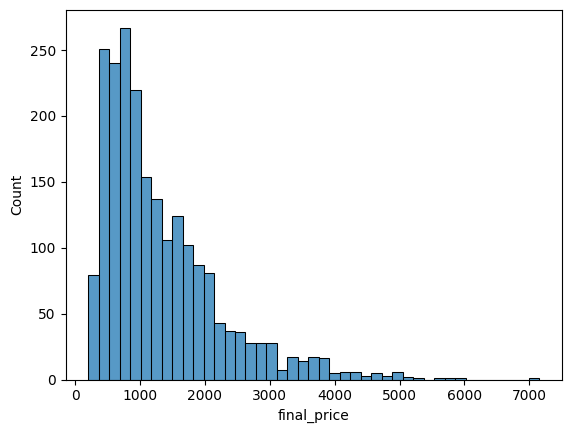

In [168]:
sns.histplot(df.final_price)

## Does the final_price have a long tail?
### Yes. This means we should need to use np.log1p(of output values). However, since we are not told to do so, we won't

In [169]:
dfUsed = df[useCols]
dfUsed.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## There's one column with missing values. What is it?
### (c) 'screen'

In [170]:
dfUsed.ram.median()

np.float64(16.0)

# Question 2
## What's the median (50% percentile) for variable 'ram'?
## 16

# Question 3
## Prep

In [172]:
dataLength = len(dfUsed)
twentyP = int(0.2 * dataLength)
testSize = dataLength - 2 * twentyP
idx = np.arange(dataLength)
np.random.seed(42)
np.random.shuffle(idx)
trainData = dfUsed.iloc[idx[:testSize]].reset_index(drop=True)
valData = dfUsed.iloc[idx[testSize:testSize + twentyP]].reset_index(drop=True)
testData = dfUsed.iloc[idx[testSize + twentyP:]].reset_index(drop=True)
len(trainData), len(valData), len(testData)

(1296, 432, 432)

In [173]:
yTrain = trainData.final_price.values
yVal = valData.final_price.values
yTest = testData.final_price.values

del trainData["final_price"]
del valData["final_price"]
del testData["final_price"]
trainData

,ram,storage,screen
0,32,1000,15.6
1,4,64,14.1
2,32,1000,14.0
3,16,512,13.3
4,32,1000,16.0
...,...,...,...
1291,8,256,14.0
1292,32,1000,16.0
1293,16,512,15.6
1294,16,512,14.0


In [174]:
def train_lin_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XT = X.T
    XTX = XT.dot(X) # called the Gram Matrix
    # add our regularization variable to the diagonal
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = (XTX_inv.dot(XT)).dot(y)
    return w_full[0], w_full[1:]

In [175]:
def prepare_X(df, fill=0):
    df = df.copy()
    #df['age'] = 2017 - df.year
    #features = base.copy()
    #features.append('age')

    #for v in [2,3,4]:
    #    df['num_doors_%d' % v] = (df.number_of_doors == v).astype("int")
    #    features.append('num_doors_%d' % v)

    #for cat, values in categories.items():
    #    for value in values:
    #        df['%s_%s' % (cat, value)] = (df[cat] == value).astype("int")
    #        features.append('%s_%s' % (cat, value))
                        
    #df_num = df[features].fillna(0)
    df_num = df.fillna(fill)
    return df_num.values

In [176]:
def RMSE(pred, actual):
    return round(np.sqrt(np.mean((pred - actual)**2)), 2)

In [177]:
xTrain = prepare_X(trainData, trainData.screen.mean())
w0, w = train_lin_regression_reg(xTrain, yTrain)
y_pred = w0 + xTrain.dot(w)
RMSE(y_pred, yTrain)

np.float64(602.18)

In [178]:
xTrain = prepare_X(trainData) # 
w0, w  = train_lin_regression_reg(xTrain, yTrain)
y_pred = w0 + xTrain.dot(w)
RMSE(y_pred, yTrain)

np.float64(602.39)

## Q3: is RMSE different if we use 0 or screen.mean to fill empty values
### With mean (barely better ... results are really bad and we should be using log1p

# Q4
## Prep

In [179]:
X_train = prepare_X(trainData) # should be ok but just double-checking
X_val = prepare_X(valData)

for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_lin_regression_reg(X_train, yTrain, r)

    y_pred = w0 + X_val.dot(w)
    rmse = RMSE(yVal, y_pred)
    print(r, rmse)
    

0.0 597.36
0.01 597.36
0.1 597.35
1 597.21
5 597.01
10 597.06
100 597.9


##### Question: Which r value gives the best RMSE? 0, 0.1, 1,10, 100?
### 5 => returns 597.01

# Q5
## Prep

In [180]:
rmses = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(dataLength)
    np.random.seed(seed)
    np.random.shuffle(idx)
    trainData = dfUsed.iloc[idx[:testSize]].reset_index(drop=True)
    valData = dfUsed.iloc[idx[testSize:testSize + twentyP]].reset_index(drop=True)
    testData = dfUsed.iloc[idx[testSize + twentyP:]].reset_index(drop=True)

    yTrain = trainData.final_price.values
    yVal = valData.final_price.values
    yTest = testData.final_price.values
    
    del trainData["final_price"]
    del valData["final_price"]
    del testData["final_price"]

    xTrain = prepare_X(trainData)
    xVal = prepare_X(valData)

    w0, w = train_lin_regression_reg(xTrain, yTrain)
    yPred = w0 + xVal.dot(w)
    rmses.append(RMSE(yVal, yPred))     

## Question: what is STD of all 10 seed values?

In [181]:
"Answer: " + str(round(np.std(rmses), 3))

'Answer: 29.176'

# Q6
## Prep

In [188]:
idx = np.arange(dataLength)
np.random.seed(9)
np.random.shuffle(idx)
trainData = dfUsed.iloc[idx[:testSize]].reset_index(drop=True)
valData = dfUsed.iloc[idx[testSize:testSize + twentyP]].reset_index(drop=True)
testData = dfUsed.iloc[idx[testSize + twentyP:]].reset_index(drop=True)

yTrain = trainData.final_price.values
yVal = valData.final_price.values
yTest = testData.final_price.values

del trainData["final_price"]
del valData["final_price"]
del testData["final_price"]

xFullTrain = pd.concat([trainData, valData]).reset_index(drop=True)
yFullTrain = np.concatenate([yTrain, yVal])
xTrain = prepare_X(xFullTrain)
xTest = prepare_X(testData)

w0, w = train_lin_regression_reg(xTrain, yFullTrain, 0.001)
yPred = w0 + xTest.dot(w)
rmse = RMSE(yPred, yTest)

## Qestion: what is the RMSE on the test dataset?

In [189]:
"Answer: " + str(rmse)

'Answer: 608.61'